In [ ]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import cv2
import os 
import imageio 
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from collections import Counter

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM, Activation,concatenate,add
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# load images 

H = 148
W = 250
path=''
images = sorted(glob(os.path.join(path, '/content/drive/MyDrive/ids/*')))
image_list=[]
for x in tqdm(images, total=len(images)):    
        x = imageio.imread(x)
        x = cv2.resize(x, (W, H))
        image_list.append(x)

100%|██████████| 5190/5190 [02:05<00:00, 41.26it/s] 


In [ ]:
image_list[0].shape

(148, 250, 3)

In [ ]:
path = "/content/drive/MyDrive/ids/"
labels=[]
names=os.listdir(path)
for n in names:
  labels.append(os.path.splitext(n)[0])
labels=sorted(labels)
labels[:5]

['٠٠ ٠٢٦ ٤ ٩ ٠٢ ٤٠ ١٧ ٠ ',
 '٠٠ ٠٦٧ ١ ٣ ٧٤ ١٦ ٤٤ ٧ ',
 '٠٠ ٠٦٨ ١ ٥ ٤٢ ٩٦ ٤٨ ٨ ',
 '٠٠ ٠٧٦ ٩ ٣ ٩٧ ٦٧ ٩٩ ٤ ',
 '٠٠ ٠٨٣ ٢ ٨ ٩١ ٠٩ ٢٠ ٢ ']

In [ ]:
# we want he time step to be the width of the image 
# so ewe need to transpose the image 
#Images=image_list[:5000]

Images=[]
for i in range (len(image_list)):
   img = tf.transpose(image_list[i],perm=[1,0,2])
   Images.append(img)

In [ ]:
#Images[0].shape

Text(0.5, 1.0, 'image-2')

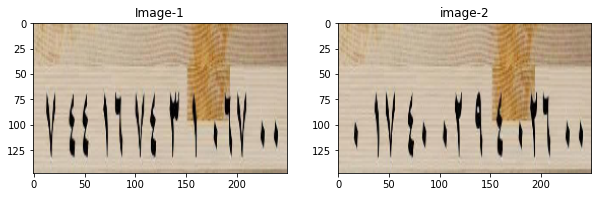

In [ ]:
fig ,arr  = plt.subplots(1,2,figsize=(10,10))
arr[0].imshow(image_list[1])
arr[0].set_title('Image-1')
arr[1].imshow(image_list[0])
arr[1].set_title('image-2')

In [ ]:
Characters = set( char for label in labels for char in label )
Max_Length = max([len(label) for label in labels ])

In [ ]:
print( 'Number of images found: ', len(image_list) )
print( 'Number of labels found: ', len(labels), '\n' )
print( 'Characters present: ', Characters ) 
print( 'Number of unique characters: ', len(Characters) )
print( 'Maxium length of any captcha image: ', Max_Length )

Number of images found:  5190
Number of labels found:  5190 

Characters present:  {'٠', '٤', '١', '٧', '٣', '٨', '٦', '٩', '٥', ' ', '٢'}
Number of unique characters:  11
Maxium length of any captcha image:  22


In [ ]:
# Mapping characters to integers
char_to_num = tf.keras.layers.StringLookup(
                  vocabulary=sorted(list(Characters)), num_oov_indices=0 )

# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
                 vocabulary=char_to_num.get_vocabulary(), invert=True )

/usr/local/lib/python3.8/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
vocab=char_to_num.get_vocabulary()
vocab_dict={k:v for v,k in enumerate(vocab)}
vocab_dict_reversed = {y:x for x,y in vocab_dict.items()}

In [ ]:
vocab_dict

{' ': 0,
 '٠': 1,
 '١': 2,
 '٢': 3,
 '٣': 4,
 '٤': 5,
 '٥': 6,
 '٦': 7,
 '٧': 8,
 '٨': 9,
 '٩': 10}

In [ ]:
encoded_la=[]
for label in labels :
   label = char_to_num( tf.strings.unicode_split(label, input_encoding='UTF-8'))
   encoded_la.append(label)

In [ ]:
encoded_la[0]

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([ 1,  1,  0,  1,  3,  7,  0,  5,  0, 10,  0,  1,  3,  0,  5,  1,  0,
        2,  8,  0,  1,  0])>

In [ ]:
x=np.array(Images)
y=np.array(encoded_la)

In [ ]:
x.shape

(5190, 250, 148, 3)

In [ ]:
len(Images)

5190

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
y_train = pad_sequences(y_train, maxlen=Max_Length)
y_test = pad_sequences(y_test, maxlen=Max_Length)

In [ ]:
print(y_train[0])
print(x_train.shape)

[ 1  4  0  5  7  6  0  6  0  5  0  8  3  0  8  6  0  2  6  0 10  0]
(4152, 250, 148, 3)


In [ ]:
# Build an endpoint layer for implementing CTC loss.
class CTCLayer( layers.Layer ):
    def __init__( self, name=None, **kwargs ):
        super().__init__( name=name )
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast( tf.shape(y_true)[0], dtype='int64' )
        input_length = tf.cast( tf.shape(y_pred)[1], dtype='int64' )
        label_length = tf.cast( tf.shape(y_true)[1], dtype='int64' )
        
        input_length = input_length*tf.ones( shape=(batch_len,1), dtype='int64' )
        label_length = label_length*tf.ones( shape=(batch_len,1), dtype='int64' )

        loss = self.loss_fn( y_true, y_pred, input_length, label_length )
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
## Model
def Build_Model():
    input_tensor = Input( (W,H,3) , dtype='float32', name='Input' )
    labels = Input( shape=(None,) , dtype='float32', name="Label" )
    scaling = tf.keras.layers.Rescaling(1./255)(input_tensor)

    # convolution block
    inner = Conv2D(128, 7, padding='same', name='conv1', kernel_initializer='he_normal', activation = 'relu')(scaling)  

    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  

    inner = Conv2D(64, 3, padding='same', name='conv2', kernel_initializer='he_normal', activation = 'relu')(inner)  

    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner) 

    inner = Conv2D(32, 3, padding='same', name='conv3', kernel_initializer='he_normal', activation = 'relu')(inner)  

    Conv_Shape = inner.get_shape( )
    inner = Reshape(target_shape=(int(Conv_Shape[1]),int(Conv_Shape[2]*Conv_Shape[3])), name='Reshape' )(inner) 
   
    # RNNs
    lstm_1 = Bidirectional(LSTM (256, return_sequences=True, kernel_initializer='he_normal'), name='LSTM_1' )(inner)
    lstm_1b = Bidirectional(LSTM (256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', dropout= 0.4), name='LSTM_2' )(lstm_1)
    lstm_2b = Bidirectional(LSTM (256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', dropout=0.4 ), name='LSTM_3' )(lstm_1)
    lstm1_merged = add([lstm_2b, lstm_1b]) 
 

    # Output layer
    x = Dense( len(Characters)+1, activation='softmax', name='Softmax' )(lstm1_merged) 

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer( name='CTC_Loss' )(labels, x)
    
    # Define the model
    model = Model( inputs=[input_tensor,labels], outputs=[output], name='CRNN_Model_with_CTC_LOSS' )    
    
    # Compile the model and return
    model.compile(optimizer=Adam(lr=0.001))
    
    return model

CRNN = Build_Model()
CRNN.summary()

Model: "CRNN_Model_with_CTC_LOSS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 250, 148, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 250, 148, 3)  0           ['Input[0][0]']                  
                                                                                                  
 conv1 (Conv2D)                 (None, 250, 148, 12  18944       ['rescaling_3[0][0]']            
                                8)                                                                
                                                                           

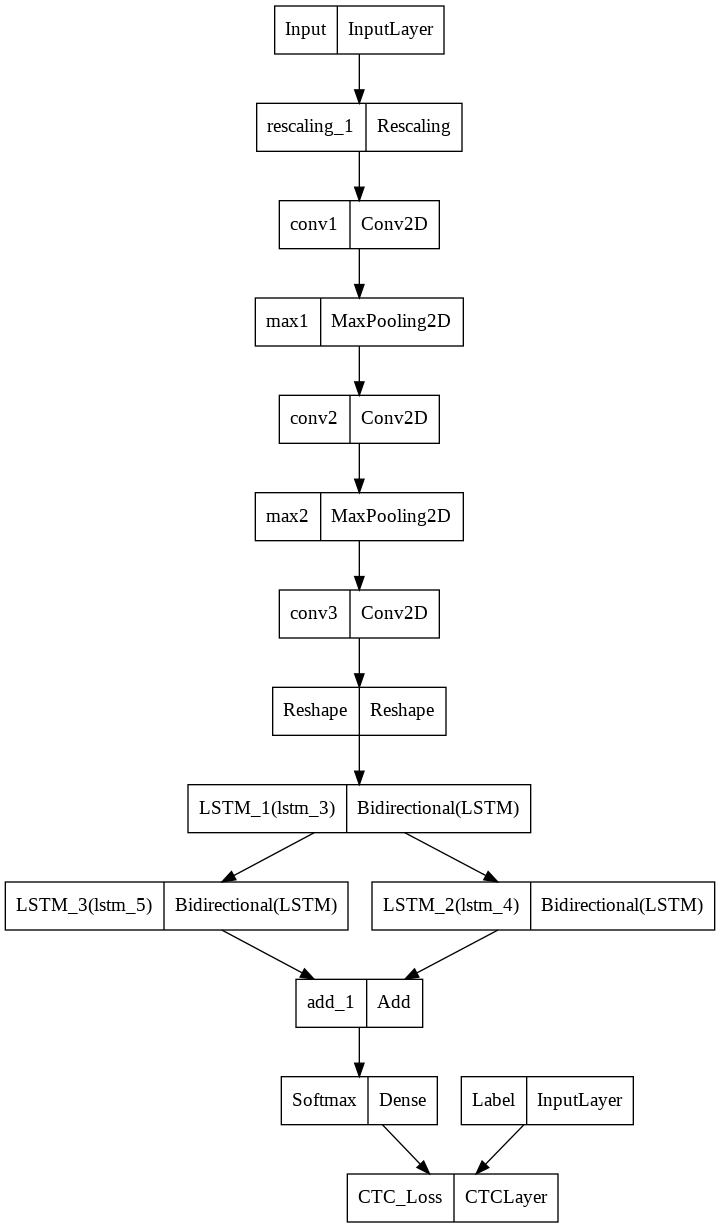

In [ ]:
tf.keras.utils.plot_model(CRNN)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
History = CRNN.fit([x_train,y_train], validation_split=0.2, epochs=100,batch_size=64,callbacks=[callback])

Epoch 1/100
52/52 [==============================] - 29s 403ms/step - loss: 51.2073 - val_loss: 46.2493
Epoch 2/100
52/52 [==============================] - 19s 363ms/step - loss: 45.7434 - val_loss: 44.8566
Epoch 3/100
52/52 [==============================] - 19s 360ms/step - loss: 44.8711 - val_loss: 45.2602
Epoch 4/100
52/52 [==============================] - 19s 359ms/step - loss: 44.3281 - val_loss: 43.6899
Epoch 5/100
52/52 [==============================] - 19s 362ms/step - loss: 43.7210 - val_loss: 43.1233
Epoch 6/100
52/52 [==============================] - 19s 371ms/step - loss: 40.7953 - val_loss: 37.2024
Epoch 7/100
52/52 [==============================] - 19s 363ms/step - loss: 35.4692 - val_loss: 32.0004
Epoch 8/100
52/52 [==============================] - 19s 360ms/step - loss: 30.4681 - val_loss: 26.7755
Epoch 9/100
52/52 [==============================] - 19s 361ms/step - loss: 25.1935 - val_loss: 21.1491
Epoch 10/100
52/52 [==============================] - 19s 361ms/

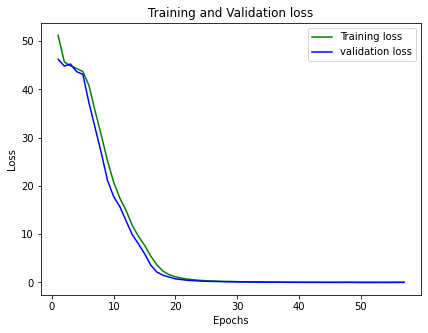

In [ ]:
loss_train = History.history['loss']
loss_val = History.history['val_loss']

epochs = range(1,len(loss_train)+1)
plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
prediction_model = Model(
    CRNN.get_layer(name="Input").input, CRNN.get_layer(name="Softmax").output
)
prediction_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 250, 148, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 250, 148, 3)  0           ['Input[0][0]']                  
                                                                                                  
 conv1 (Conv2D)                 (None, 250, 148, 12  18944       ['rescaling[0][0]']              
                                8)                                                                
                                                                                              

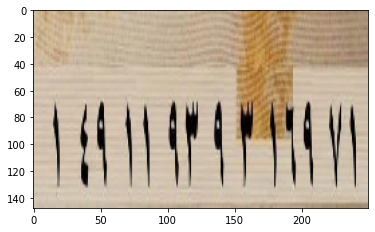

predicted text = ٧١ ١٦٩ ٣ ٩ ٩٣ ١١ ٤٩ ١ 



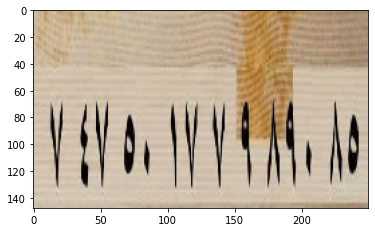

predicted text = ٨٥ ٨٩٠ ٩ ٧ ١٧ ٥٠ ٤٧ ٧ 



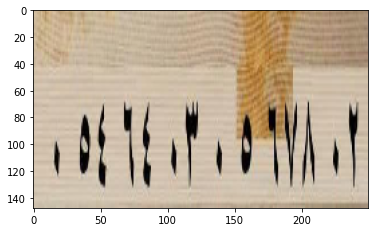

predicted text = ٠٢ ٦٧٨ ٥ ٠ ٠٣ ٦٤ ٥٤ ٠ 



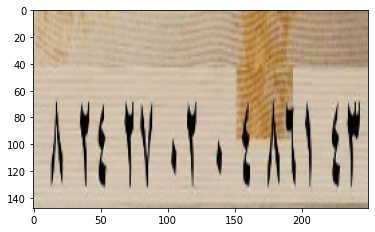

predicted text = ٤٣ ٨٦١ ٤ ٠ ٠٢ ٢٧ ٢٤ ٨ 



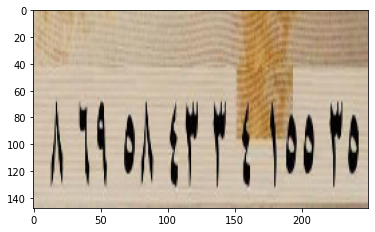

predicted text = ٣٥ ١٥٥ ٤ ٣ ٤٣ ٥٨ ٦٩ ٨ 



In [ ]:
prediction = prediction_model(x_test[0:5])

out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

## get the final text    
i=0 
for x in out:
    plt.imshow(x_test[i].transpose(1,0,2))
    plt.show()
    print("predicted text = ", end = '')
    
    for p in x:
        if int(p) != -1:
            print(vocab_dict_reversed[int(p)], end = '')
            
    print('\n')
    i+=1

In [ ]:
CRNN.save('final.h5')